In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.forecasting.base import ForecastingHorizon
# from sktime.forecasting.compose import (
#     EnsembleForecaster,
#     ReducedRegressionForecaster,
#     TransformedTargetForecaster,
# )


from sktime.forecasting.model_selection import (
#     ForecastingGridSearchCV,
#     SlidingWindowSplitter,
    temporal_train_test_split,
)

from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [2]:
df = pd.read_csv('./precipitation_bra.csv')

df.date = pd.to_datetime(df.date)

df.set_index('date', inplace = True)

df


,datatype,station,value,fl_miss,fl_cmiss,country,indicator
date,,,,,,,
2010-01-01,TPCP,GHCND:BR000352000,3397,0,0,Brazil,TPCP
2010-01-01,TPCP,GHCND:BR000956000,2979,0,0,Brazil,TPCP
2010-01-01,TPCP,GHCND:BR002143012,2724,0,0,Brazil,TPCP
2010-01-01,TPCP,GHCND:BR00E3-0520,5750,0,0,Brazil,TPCP
2010-01-01,TPCP,GHCND:BR037041370,1670,0,0,Brazil,TPCP
...,...,...,...,...,...,...,...
2015-04-01,TPCP,GHCND:BR037041370,2119,0,0,Brazil,TPCP
2015-04-01,TPCP,GHCND:BR038484280,316,0,0,Brazil,TPCP
2015-04-01,TPCP,GHCND:BR038837530,432,0,0,Brazil,TPCP


In [3]:

yyyymm = df.index.to_period('M')

df = df.groupby(yyyymm).mean()['value']
df.index

PeriodIndex(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
             '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
             '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
             '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
             '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
             '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
             '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
             '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
             '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
             '2015-01', '2015-02', '2015-03', '2015-04'],
            dtype='period[M]', name='date', freq='M')

In [4]:
df.name = 'precipitation'

In [240]:
from sktime.utils.validation._dependencies import _check_soft_dependencies
from sktime.utils.validation.forecasting import check_y


def plot_series(*series, labels=None):
    """Plot one or more time series
    Parameters
    ----------
    series : pd.Series
        One or more time series
    labels : list, optional (default=None)
        Names of series, will be displayed in figure legend
    Returns
    -------
    fig : plt.Figure
    ax : plt.Axis
    """
    _check_soft_dependencies("matplotlib", "seaborn")
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter, MaxNLocator
    from matplotlib.cbook import flatten
    import seaborn as sns

    n_series = len(series)
    if labels is not None:
        if n_series != len(labels):
            raise ValueError(
                "There must be one label for each time series, "
                "but found inconsistent numbers of series and "
                "labels."
            )
        legend = True
    else:
        labels = ["" for _ in range(n_series)]
        legend = False

    for y in series:
        check_y(y)

    # create combined index
    index = series[0].index
    for y in series[1:]:
        # check types, note that isinstance() does not work here because index
        # types inherit from each other, hence we check for type equality
        if not type(index) is type(y.index):  # noqa
            raise TypeError("Found series with different index types.")
        index = index.union(y.index)

    # generate integer x-values
    xs = [np.argwhere(index.isin(y.index)).ravel() for y in series]

    # create figure
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
    colors = sns.color_palette("colorblind", n_colors=n_series)

    # plot series
    for x, y, color, label in zip(xs, series, colors, labels):

        # scatter if little data is available or index is not complete
        if len(x) <= 3 or not np.array_equal(np.arange(x[0], x[-1] + 1), x):
            plot_func = sns.scatterplot
        else:
            plot_func = sns.lineplot

        plot_func(x=x, y=y, ax=ax, marker="o", ms =.1, label=label, color=color)

    # combine data points for all series
    xs_flat = list(flatten(xs))
    
    

    # set x label of data point to the matching index
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in xs_flat:
            return index[int(tick_val)]
        else:
            return ""
   

    print(MaxNLocator(integer=True))
    
    # dynamically set x label ticks and spacing from index labels
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if legend:
        ax.legend()

    return fig, ax

# print (plot_series)

# ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])

# plot_series_github(y_train, y_test, labels=["y_train", "y_test"])
import sktime
print(sktime.__file__)
print(sktime.__version__)

/opt/anaconda3/envs/cssp/lib/python3.8/site-packages/sktime/__init__.py
0.5.2


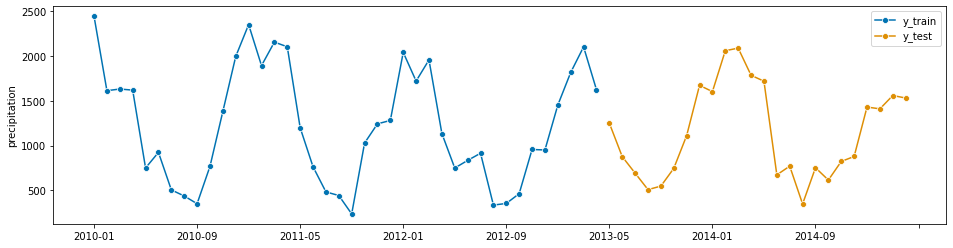

In [11]:
y_train, y_test = temporal_train_test_split(df, test_size=24)

# from sktime.utils.plotting import plot_series
# from plotting import plot_series as plot_series_local

from plotting import plot_series as plot_series

# generic import
ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])
# # local import
# ax1 = plot_series_local(y_train, y_test, labels=["y_train", "y_test"])
# # inline paste
# ax2 = plot_series_github(y_train, y_test, labels=["y_train", "y_test"])


In [53]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh.name = 'Period'
fh

ForecastingHorizon(['2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10',
             '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04',
             '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10',
             '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04'],
            dtype='period[M]', name='date', freq='M', is_relative=False)

In [68]:
forecaster = ThetaForecaster(sp=12, deseasonalise=True)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

0.2570671195070258

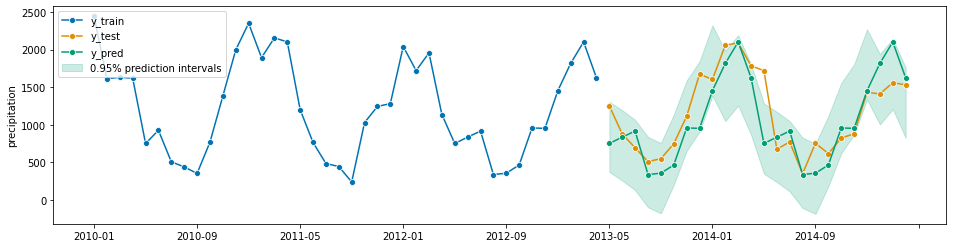

In [72]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

In [137]:
import sktime
sktime.__version__

'0.5.2'

In [73]:


y_train

date
2010-01    2444.538462
2010-02    1613.153846
2010-03    1631.500000
2010-04    1619.285714
2010-05     749.500000
2010-06     924.000000
2010-07     504.846154
2010-08     436.666667
2010-09     350.384615
2010-10     767.500000
2010-11    1381.846154
2010-12    1995.714286
2011-01    2351.230769
2011-02    1893.076923
2011-03    2155.714286
2011-04    2103.461538
2011-05    1199.000000
2011-06     762.916667
2011-07     482.272727
2011-08     442.076923
2011-09     236.500000
2011-10    1028.071429
2011-11    1242.733333
2011-12    1280.500000
2012-01    2041.000000
2012-02    1720.600000
2012-03    1956.857143
2012-04    1134.642857
2012-05     749.071429
2012-06     834.142857
2012-07     914.333333
2012-08     335.272727
2012-09     353.333333
2012-10     462.500000
2012-11     956.285714
2012-12     950.769231
2013-01    1452.250000
2013-02    1816.642857
2013-03    2102.357143
2013-04    1623.666667
Freq: M, Name: precipitation, dtype: float64

In [78]:
fh2 = ForecastingHorizon(y_train.index, is_relative=False)
fh2

ForecastingHorizon(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
             '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
             '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
             '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
             '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
             '2013-01', '2013-02', '2013-03', '2013-04'],
            dtype='period[M]', name='date', freq='M', is_relative=False)

0.17823167434692253

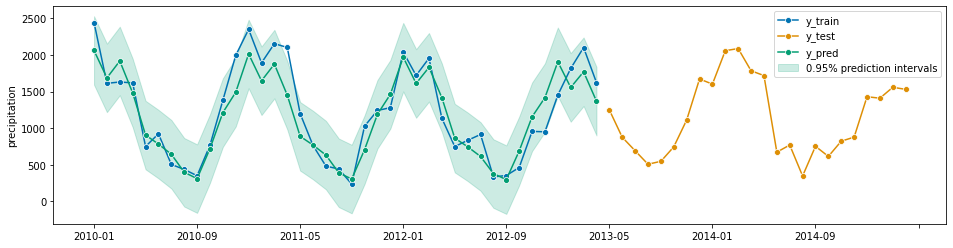

In [80]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh2, return_pred_int=True, alpha=alpha)
# smape_loss(y_test, y_pred)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

smape_loss(y_train, y_pred)

In [216]:
t = pd.read_csv('monthly_csv.csv')
# a = t.groupby('Date').mean()['Mean']
a = t[t.Source=='GISTEMP']
a = a.groupby('Date').mean()['Mean']
a.index = pd.to_datetime(a.index).to_period('M')

# we cant deal with negative values - so we shift up by 1
a+=1
# filter from 1980 onwards
a = a['19800101':]

a

Date
1980-01    1.30
1980-02    1.42
1980-03    1.29
1980-04    1.32
1980-05    1.34
           ... 
2016-08    1.98
2016-09    1.87
2016-10    1.89
2016-11    1.93
2016-12    1.81
Freq: M, Name: Mean, Length: 444, dtype: float64

In [260]:
y_train, y_test = temporal_train_test_split(a, test_size=12*4)


# predict = df.index+12*4
fh3 = ForecastingHorizon(y_test.index, is_relative=False)# using timepoints
# fh3 = np.arange(12*31) + 1 -(12*22) # using relative steps from end [1,2,3...]

SMAPE:0.09711370067356599


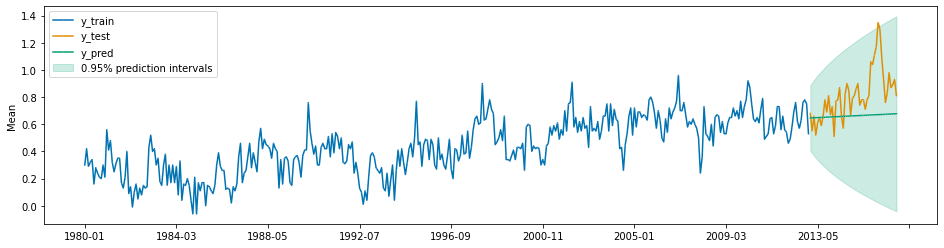

In [284]:
y_train, y_test = temporal_train_test_split(a, test_size=12*4)

fh3 = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=1*1)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh3, return_pred_int=True, alpha=alpha)
print('SMAPE:'+str(smape_loss(y_test, y_pred)))



fig, ax = plot_series(y_train-1, y_test-1, y_pred-1, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"]-1,
    pred_ints["upper"]-1,
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

theta = y_pred


In [281]:
https://www.sciencedirect.com/science/article/abs/pii/S0169207000000662
    https://www.e3s-conferences.org/articles/e3sconf/pdf/2019/10/e3sconf_pe2019_01004.pdf

SyntaxError: invalid syntax (<ipython-input-281-96b2d668eb00>, line 1)

0.22678376126806943

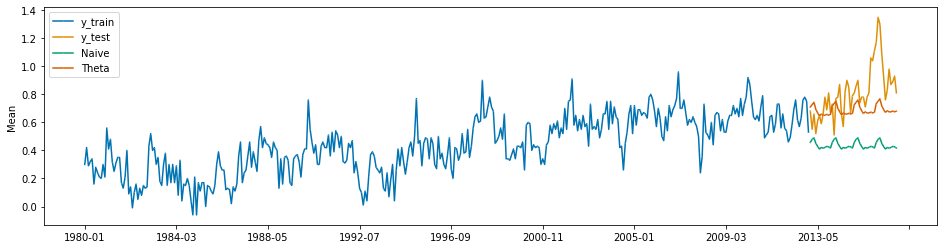

In [279]:
# Predicting the last value of the same season

from sktime.forecasting.naive import NaiveForecaster
fh = ForecastingHorizon(y_test.index, is_relative=False)# using timepoints

forecaster = NaiveForecaster(strategy="mean", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train-1, y_test-1, y_pred-1,theta-1, labels=["y_train", "y_test", "Naive",'Theta'])

smape_loss(y_test, y_pred)

In [157]:
y_train, y_test = temporal_train_test_split(df, test_size=36)
print(y_train.shape[0], y_test.shape[0])
fh = ForecastingHorizon(y_test.index, is_relative=False)

28 36


0.4109425834377018

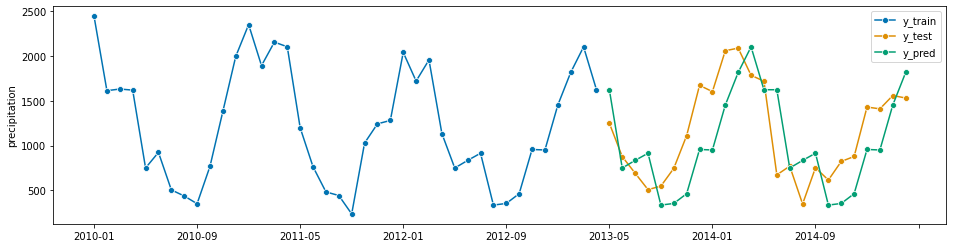

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)


regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=12, strategy="recursive"
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [20]:
# forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
# forecaster.fit(y_train)
# y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# smape_loss(y_test, y_pred)

0.4983112720461131

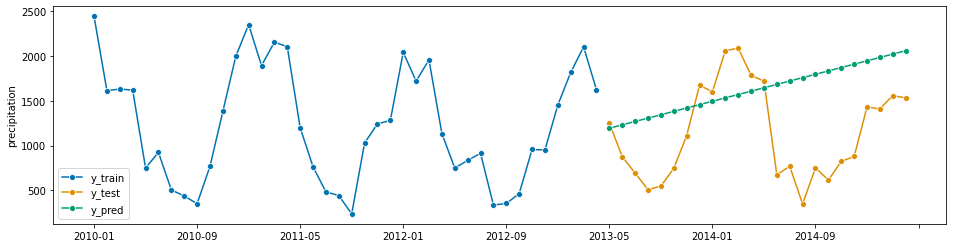

In [19]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [21]:
#tuning 
forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=15, strategy="recursive"
)
param_grid = {"window_length": [3,6,12]}

#  we fit the forecaster on the initial window,
# and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

NameError: name 'SlidingWindowSplitter' is not defined

In [171]:
from sklearn.metrics import mean_squared_error

from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)

from sktime.forecasting.exp_smoothing import ExponentialSmoothing

hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)

In [181]:
forecaster = OnlineEnsembleForecaster(
    [
        ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
        (
            "holt",
            ExponentialSmoothing(
                trend="add", damped_trend=False, seasonal="multiplicative", sp=12
            ),
        ),
        (
            "damped",
            ExponentialSmoothing(
                trend="add", damped_trend=True, seasonal="multiplicative", sp=12
            ),
        ),
    ],
    ensemble_algorithm=hedge_expert,
)



forecaster.fit(y_train)
y_pred = forecaster.update_predict(y_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test[1:], y_pred)

/opt/anaconda3/envs/cssp/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/envs/cssp/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/envs/cssp/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [177]:
y_pred


2012-05    1134.642857
2012-06     482.272727
2012-07     442.076923
2012-08     350.384615
2012-09    1028.071429
2012-10    1242.733333
2012-11    1995.714286
2012-12    2351.230769
2013-01    1893.076923
2013-02    2155.714286
2013-03    2103.461538
2013-04    1199.000000
2013-05     762.916667
2013-06     482.272727
2013-07     442.076923
2013-08     236.500000
2013-09    1028.071429
2013-10    1242.733333
2013-11    1280.500000
2013-12    2041.000000
2014-01    1720.600000
2014-02    1956.857143
2014-03    1134.642857
2014-04    1134.642857
2014-05     482.272727
2014-06     442.076923
2014-07     350.384615
2014-08    1028.071429
2014-09    1242.733333
2014-10    1995.714286
2014-11    2351.230769
2014-12    1893.076923
2015-01    2155.714286
2015-02    2103.461538
2015-03    1199.000000
2015-04     762.916667
Freq: M, dtype: float64